In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# **Load and Prepare Data**

In [2]:
df = pd.read_csv('AMZN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# **Plot the original time series**

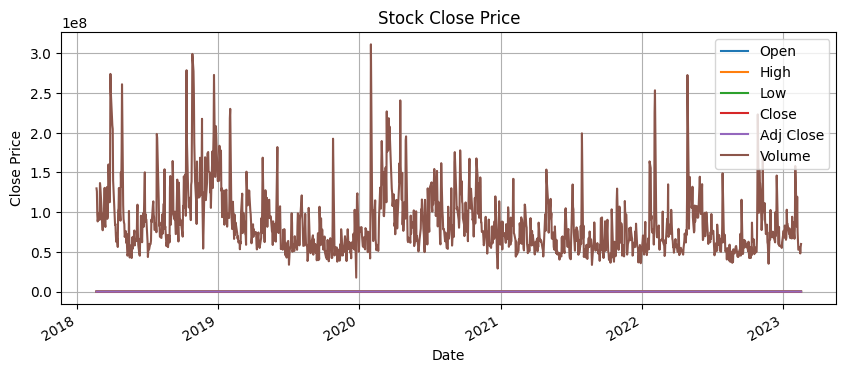

In [4]:
df.plot(title="Stock Close Price", ylabel='Close Price', figsize=(10, 4), grid=True)
plt.show()

# **Stationarity Check**

In [5]:
result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737


In [8]:
# Differencing if not stationary
df_diff = df['Close'].diff().dropna()
result_diff = adfuller(df_diff)
print("\nAfter Differencing:")
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])


After Differencing:
ADF Statistic: -36.25077933242776
p-value: 0.0


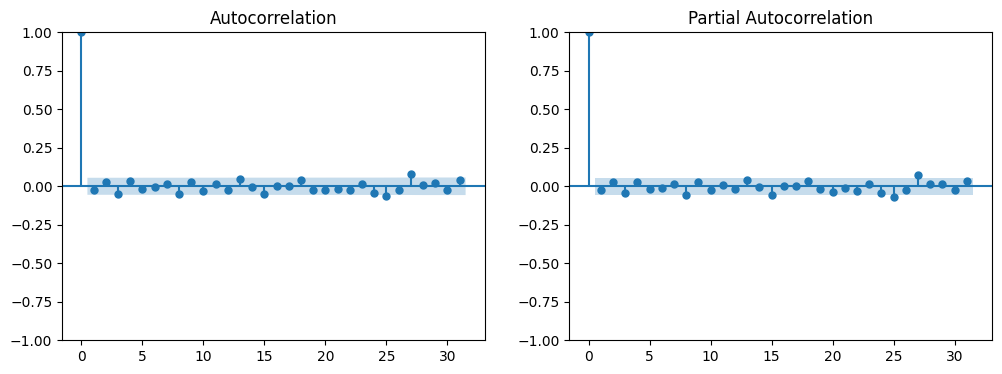

In [10]:
# ACF and PACF plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_diff, ax=ax[0])
plot_pacf(df_diff, ax=ax[1])
plt.show()

# **ARIMA Model**

In [12]:
model = ARIMA(df['Close'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3062.845
Date:                Tue, 08 Apr 2025   AIC                           6131.691
Time:                        15:39:51   BIC                           6147.102
Sample:                             0   HQIC                          6137.482
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6794      0.242     -2.810      0.005      -1.153      -0.206
ma.L1          0.6439      0.251      2.560      0.010       0.151       1.137
sigma2         7.6258      0.173     44.046      0.0

In [13]:
# Forecast next 5 days
forecast = model_fit.forecast(steps=5)
forecast_dates = pd.date_range(df.index[-1], periods=6, freq='B')[1:]
forecast_series = pd.Series(forecast, index=forecast_dates)

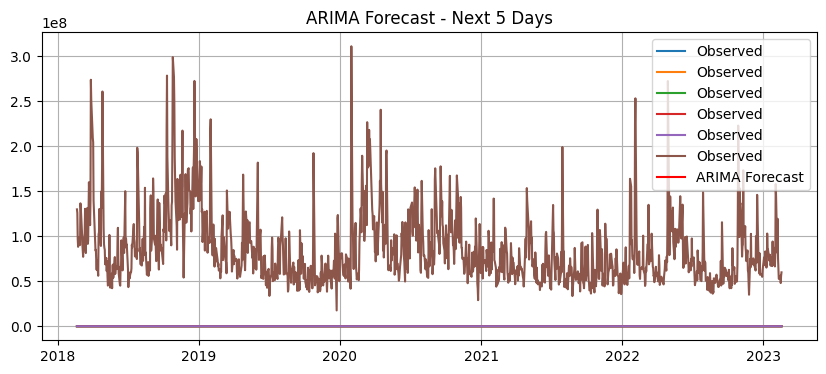

In [14]:
# Plot forecast
plt.figure(figsize=(10, 4))
plt.plot(df, label='Observed')
plt.plot(forecast_series, label='ARIMA Forecast', color='red')
plt.legend()
plt.title("ARIMA Forecast - Next 5 Days")
plt.grid()
plt.show()

# **RNN / LSTM Model**

In [16]:
# Scale only the 'Close' values
scaled_close = scaler.fit_transform(df[['Close']])
window = 3
X, y = create_sequences(scaled_close, window)
X = X.reshape((X.shape[0], X.shape[1], 1))

# **Split into training and testing**

In [17]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# **Build and train LSTM**

In [18]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model.fit(X_train, y_train, epochs=300, verbose=0)

In [19]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

print("\nLSTM Model Evaluation:")
print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
print("RMSE:", sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

LSTM Model Evaluation:
MAE: 2.775903156000047
RMSE: 3.6894249858658195


# **Forecast future 5 steps**

In [21]:
input_seq = scaled_close[-window:].reshape(window,)

future_preds = []
for _ in range(24):
    pred = model.predict(input_seq.reshape(1, window, 1), verbose=0)

    future_preds.append(pred[0, 0])

    input_seq = np.append(input_seq[1:], pred[0, 0])

In [24]:
future_preds_array = np.array(future_preds).reshape(-1, 1)
future_preds_actual = scaler.inverse_transform(future_preds_array)

last_date = df.index[-1]  # assuming df index is datetime
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=24, freq='B')  # 'B' = business day

forecast_series = pd.Series(future_preds_actual.flatten(), index=forecast_dates)

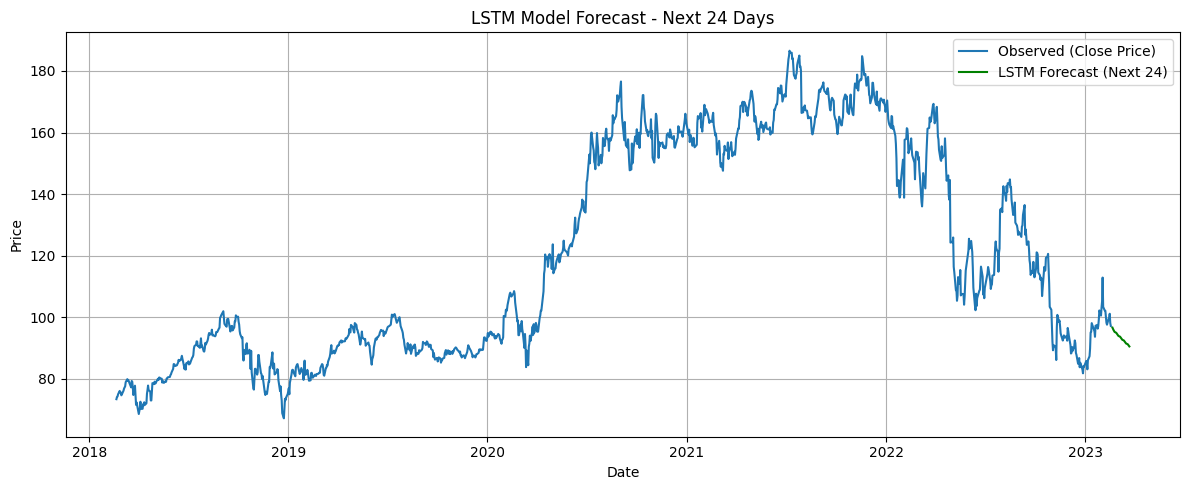

In [25]:
# Plot observed data and forecast
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Observed (Close Price)')
plt.plot(forecast_series, label='LSTM Forecast (Next 24)', color='green')
plt.title('LSTM Model Forecast - Next 24 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()